# Installs

In [ ]:
# !pip install transformers --q

In [ ]:
# !pip install torch --q

In [ ]:
# pip install einops --q

In [ ]:
# pip install biopython --q

Note: you may need to restart the kernel to use updated packages.


# Imports

In [ ]:
from Bio import SeqIO
import torch
from transformers import AutoTokenizer, AutoModel
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from transformers import TFBertForSequenceClassification
from transformers import OpenAIGPTConfig, OpenAIGPTModel
import torch
import pandas as pd
from tokenizers import Tokenizer
from tokenizers.models import BPE, Unigram, WordLevel, WordPiece
from tokenizers.trainers import BpeTrainer, WordLevelTrainer,WordPieceTrainer, UnigramTrainer
from tokenizers.pre_tokenizers import Sequence, Digits, Whitespace
from transformers import PreTrainedTokenizerFast
import random
from tokenizers import Tokenizer, models, trainers
from transformers import BertConfig, BertForSequenceClassification, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, BertForMaskedLM
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertForMaskedLM
from tqdm import tqdm
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel , RobertaTokenizer, TFRobertaModel , AutoTokenizer, AutoModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from transformers import RobertaForMaskedLM, RobertaTokenizer, RobertaTokenizerFast, RobertaConfig
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors
from transformers import RobertaForSequenceClassification
import os
from sklearn.metrics import confusion_matrix
import json

/storage/modules/packages/anaconda/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/storage/modules/packages/anaconda/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

# Tokenizers

את שני התאים הבאים צריך להריץ בשביל המסקינג

In [ ]:
all_data_pos = pd.read_csv('data_exp1/all_data_combined_df.csv', index_col = False)
all_data_pos['True_label']=1

train_df, validation_df = train_test_split(all_data_pos, test_size=0.2, random_state=42)

In [ ]:
#this will be used for training the tokenizers
df_sequences = all_data_pos['seq'].tolist()
df_labels = all_data_pos['True_label'].tolist()

#this will be used for the pre-train(masking)
df_train_sequences = train_df['seq'].tolist()
df_train_labels = train_df['True_label'].tolist()

df_val_sequences = validation_df['seq'].tolist()
df_val_labels = validation_df['True_label'].tolist()

# wpc - Pretrained

In [ ]:
class DNADataset(Dataset):
    def __init__(self, sequences, tokenizer, max_length=6):
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        inputs = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension
        inputs['labels'] = inputs['input_ids'].clone()
        return inputs

In [ ]:
UNK_TOKEN = "[UNK]"  # token for unknown words
SPL_TOKENS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

In [ ]:
def batch_iterator(dataset):
    batch_size = 10000
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]


def train_biological_tokenizer():

    """
    Reads the data from folder, trains the tokenizer, encode the sequences and returns list of data for BERT training
    """
    X_train = df_sequences
    y_train = df_labels
    tokenizer = Tokenizer(WordPiece(unk_token = UNK_TOKEN, max_input_chars_per_word=601))
    trainer = WordPieceTrainer(special_tokens = SPL_TOKENS, continuing_subword_prefix="")
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train_from_iterator(batch_iterator(X_train), trainer) # training the tokenzier

    return tokenizer

In [ ]:
tokenizer = train_biological_tokenizer()

In [ ]:
from collections import defaultdict
vocab = tokenizer.get_vocab()

# Initialize a dictionary to store counts of each token length
token_length_counts = defaultdict(int)

# Iterate through the vocabulary and count the lengths of the tokens
for token in vocab:
    token_length = len(token)
    token_length_counts[token_length] += 1

# Sort the counts by token length
sorted_token_length_counts = dict(sorted(token_length_counts.items()))

# Print the counts of tokens for each length
for length, count in sorted_token_length_counts.items():
    print(f"Token length: {length}, Count: {count}")

Token length: 1, Count: 5
Token length: 2, Count: 14
Token length: 3, Count: 42
Token length: 4, Count: 158
Token length: 5, Count: 390
Token length: 6, Count: 1143
Token length: 7, Count: 4412
Token length: 8, Count: 11231
Token length: 9, Count: 9177
Token length: 10, Count: 2349
Token length: 11, Count: 589
Token length: 12, Count: 258
Token length: 13, Count: 49
Token length: 14, Count: 33
Token length: 15, Count: 21
Token length: 16, Count: 38
Token length: 17, Count: 3
Token length: 18, Count: 13
Token length: 19, Count: 5
Token length: 20, Count: 13
Token length: 21, Count: 3
Token length: 22, Count: 1
Token length: 24, Count: 15
Token length: 25, Count: 1
Token length: 26, Count: 1
Token length: 28, Count: 3
Token length: 32, Count: 13
Token length: 35, Count: 1
Token length: 40, Count: 5
Token length: 44, Count: 2
Token length: 48, Count: 4
Token length: 64, Count: 6
Token length: 96, Count: 1
Token length: 128, Count: 1


In [ ]:
roberta_tokenizer = RobertaTokenizerFast(tokenizer_object=tokenizer, pad_token="[PAD]")

In [ ]:
roberta_tokenizer.save_pretrained("models/wpc_tokenizer_rep")

('models/wpc_tokenizer_rep/tokenizer_config.json',
 'models/wpc_tokenizer_rep/special_tokens_map.json',
 'models/wpc_tokenizer_rep/vocab.txt',
 'models/wpc_tokenizer_rep/added_tokens.json',
 'models/wpc_tokenizer_rep/tokenizer.json')

In [ ]:
# roberta_tokenizer = RobertaTokenizerFast.from_pretrained("models/wpc_tokenizer_rep")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Create a dataset object
train_dataset = DNADataset(df_train_sequences, tokenizer = roberta_tokenizer)
validation_dataset = DNADataset(df_val_sequences, tokenizer = roberta_tokenizer)

# Create a dataloader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define special tokens (if not already defined in the tokenizer)
special_tokens = {
    'pad_token': '<pad>',
    'bos_token': '<s>',
    'eos_token': '</s>',
    'unk_token': '<unk>',
    'cls_token': '<cls>',
    'sep_token': '<sep>',
    'mask_token': '<mask>'
}

# Add special tokens to the tokenizer
roberta_tokenizer.add_special_tokens({'additional_special_tokens': list(special_tokens.values())})

# Resize the tokenizer vocabulary to include the new special tokens
roberta_tokenizer.add_tokens([token for token in special_tokens.values()])

# Retrieve the special token IDs
pad_token_id = roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.pad_token)
bos_token_id = roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.bos_token)
eos_token_id = roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.eos_token)

# Print the token IDs to verify
print("Pad token ID:", pad_token_id)
print("BOS token ID:", bos_token_id)
print("EOS token ID:", eos_token_id)

# Ensure the token IDs are within the updated vocabulary size
updated_vocab_size = len(roberta_tokenizer)
assert pad_token_id < updated_vocab_size, "Padding_idx must be within num_embeddings"
assert bos_token_id < updated_vocab_size, "BOS token ID must be within num_embeddings"
assert eos_token_id < updated_vocab_size, "EOS token ID must be within num_embeddings"

Pad token ID: 0
BOS token ID: 30000
EOS token ID: 30001


In [ ]:
# # Initialize the model - pretrined model
# model = RobertaForMaskedLM.from_pretrained("roberta-base").to(device)

# Define model configuration
config = RobertaConfig(
    vocab_size=updated_vocab_size,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    pad_token_id=pad_token_id,
    bos_token_id=bos_token_id,
    eos_token_id=eos_token_id
)

# Initialize the model
model = RobertaForMaskedLM(config)

In [ ]:
# Define training parameters
num_epochs = 2
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_history=[]
val_history=[]

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        inputs = {key: val.to(model.device) for key, val in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i>0 and i % 300 ==0:
            print(f"Epoch {epoch+1}/{num_epochs}, Iteration {i}, Training Loss: {total_loss/i:.4f}")

    avg_loss = total_loss / len(train_dataloader)
    train_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for val_batch in validation_dataloader:
            val_inputs = {key: val.to(model.device) for key, val in val_batch.items()}
            val_outputs = model(**val_inputs)
            val_loss = val_outputs.loss
            val_losses.append(val_loss.item())

        avg_val_loss = sum(val_losses) / len(val_losses)
        val_history.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

/storage/modules/packages/anaconda/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Iteration 300, Training Loss: 9.3140
Epoch 1/2, Iteration 600, Training Loss: 8.3323
Epoch 1/2, Iteration 900, Training Loss: 7.5372
Epoch 1/2, Iteration 1200, Training Loss: 6.8522
Epoch 1/2, Iteration 1500, Training Loss: 6.2728
Epoch 1/2, Iteration 1800, Training Loss: 5.7801
Epoch 1/2, Iteration 2100, Training Loss: 5.3549
Epoch 1/2, Iteration 2400, Training Loss: 4.9896
Epoch 1/2, Iteration 2700, Training Loss: 4.6708
Epoch 1/2, Iteration 3000, Training Loss: 4.3873
Epoch 1/2, Iteration 3300, Training Loss: 4.1336
Epoch 1/2, Iteration 3600, Training Loss: 3.9074
Epoch 1/2, Iteration 3900, Training Loss: 3.7035
Epoch 1/2, Iteration 4200, Training Loss: 3.5182
Epoch 1/2, Iteration 4500, Training Loss: 3.3497
Epoch 1/2, Iteration 4800, Training Loss: 3.1953
Epoch 1/2, Iteration 5100, Training Loss: 3.0532
Epoch 1/2, Iteration 5400, Training Loss: 2.9230
Epoch 1/2, Iteration 5700, Training Loss: 2.8025
Epoch 1/2, Iteration 6000, Training Loss: 2.6915
Epoch 1/2, Iteration 63

In [ ]:
# Save the model
model.save_pretrained("models/wpc_masking_model_rep")

# wpc FineTune

In [ ]:
train_tata = pd.read_csv("data_exp1/train_tata_met_2.csv", index_col = False)
val_tata = pd.read_csv("data_exp1/val_tata_met_2.csv", index_col = False)
test_tata = pd.read_csv('data_exp1/test_tata_met_2.csv', index_col = False)

train_non_tata = pd.read_csv('data_exp1/train_non_tata_met_2.csv', index_col = False)
val_non_tata = pd.read_csv('data_exp1/val_non_tata_met_2.csv', index_col = False)
test_non_tata = pd.read_csv('data_exp1/test_non_tata_met_2.csv', index_col = False)

In [ ]:
train = pd.concat([train_tata, train_non_tata])
val = pd.concat([val_tata, val_non_tata])

In [ ]:
wrong_idx_dict=defaultdict(dict)

In [ ]:
class DNAClassificationDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=128):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension

        # Ensure the label is an integer
        inputs['labels'] = torch.tensor(int(label), dtype=torch.long)
        return inputs



In [ ]:
import torch
from transformers import AdamW, RobertaForSequenceClassification
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef


class ClassificationModelWPC:

    def __init__(self, train_df, val_df, test_tata_df, test_non_tata_df, organism='human', b_size=8):
        self.organism = organism
        self.batch_size = b_size
        self.dataframes = {
            'train': train_df,
            'val': val_df,
            'test_tata': test_tata_df,
            'test_non_tata': test_non_tata_df
        }

        self.tokenizer = RobertaTokenizerFast.from_pretrained("models/wpc_tokenizer_rep")
        self.masking_model = RobertaForMaskedLM.from_pretrained("models/wpc_masking_model_rep")
        self.create_model()

        # Create dataloaders and set as attributes
        dataloaders = self.create_dataloaders(batch_size=self.batch_size)
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.test_tata_dataloader = dataloaders['test_tata']
        self.test_non_tata_dataloader = dataloaders['test_non_tata']

    def filter_and_convert(self, df, organism):
        filtered_df = df[df['organism'] == organism]
        seq_list = filtered_df['seq'].tolist()
        label_list = filtered_df['True_label'].tolist()
        return seq_list, label_list

    def create_dataloaders(self, batch_size=16):
        train_seq, train_labels = self.filter_and_convert(self.dataframes['train'], self.organism)
        val_seq, val_labels = self.filter_and_convert(self.dataframes['val'], self.organism)
        test_tata_seq, test_tata_labels = self.filter_and_convert(self.dataframes['test_tata'], self.organism)
        test_non_tata_seq, test_non_tata_labels = self.filter_and_convert(self.dataframes['test_non_tata'], self.organism)

        # Create the dataset and dataloader
        train_dataset = DNAClassificationDataset(train_seq, train_labels, self.tokenizer)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = DNAClassificationDataset(val_seq, val_labels, self.tokenizer)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        test_tata_dataset = DNAClassificationDataset(test_tata_seq, test_tata_labels, self.tokenizer)
        test_tata_dataloader = DataLoader(test_tata_dataset, batch_size=batch_size, shuffle=True)

        test_non_tata_dataset = DNAClassificationDataset(test_non_tata_seq, test_non_tata_labels, self.tokenizer)
        test_non_tata_dataloader = DataLoader(test_non_tata_dataset, batch_size=batch_size, shuffle=True)

        return {
            'train': train_dataloader,
            'val': val_dataloader,
            'test_tata': test_tata_dataloader,
            'test_non_tata': test_non_tata_dataloader
        }

    def create_model(self):
        # Define configuration for sequence classification
        config = RobertaConfig.from_pretrained("models/wpc_masking_model_rep")
        config.num_labels = 2  # binary classification

        # Initialize the sequence classification model
        self.classification_model = RobertaForSequenceClassification(config)

        # Copy the pre-trained weights from the masked language model
        self.classification_model.roberta.load_state_dict(self.masking_model.roberta.state_dict())
        # return classification_model

    def train_model(self, num_epochs=60, base_lr=1e-5, patience=3):

        train_dataloader = self.train_dataloader
        val_dataloader = self.val_dataloader

        optimizer = torch.optim.AdamW(self.classification_model.parameters(), lr=base_lr)
        scheduler = MultiStepLR(optimizer, milestones=list(range(4,num_epochs+1,4)), gamma=0.85)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classification_model.to(device)

       # Initialize history dictionaries
        train_history = {
            'loss': [],
            'accuracy': []
        }
        val_history = {
            'loss': [],
            'accuracy': [],
            'f1': [],
            'auc': [],
            'mcc': []
        }

        # Initialize early stopping criteria
        best_val_accuracy = 0.0
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            # Training phase
            self.classification_model.train()
            total_train_loss = 0
            correct_train_predictions = 0
            total_train_predictions = 0

            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                loss.backward()
                optimizer.step()
                scheduler.step()

                # Calculate training accuracy
                total_train_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct_train_predictions += torch.sum(preds == labels).item()
                total_train_predictions += labels.size(0)

            avg_train_loss = total_train_loss / len(train_dataloader)
            train_accuracy = correct_train_predictions / total_train_predictions
            train_history['loss'].append(avg_train_loss)
            train_history['accuracy'].append(train_accuracy)

            # Validation phase
            self.classification_model.eval()
            total_val_loss = 0
            correct_val_predictions = 0
            total_val_predictions = 0

            all_labels = []
            all_preds = []
            all_probs = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits

                    # Calculate validation accuracy
                    total_val_loss += loss.item()
                    preds = torch.argmax(logits, dim=1)
                    probs = torch.softmax(logits, dim=1)[:, 1]

                    correct_val_predictions += torch.sum(preds == labels).item()
                    total_val_predictions += labels.size(0)

                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_accuracy = correct_val_predictions / total_val_predictions
            val_f1 = f1_score(all_labels, all_preds)
            val_auc = roc_auc_score(all_labels, all_probs)
            val_mcc = matthews_corrcoef(all_labels, all_preds)

            val_history['loss'].append(avg_val_loss)
            val_history['accuracy'].append(val_accuracy)
            val_history['f1'].append(val_f1)
            val_history['auc'].append(val_auc)
            val_history['mcc'].append(val_mcc)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Check early stopping criteria
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered")
                    break

        # Save the trained classification model
        self.classification_model.save_pretrained(f"models/wpc fine tune models/method2/wpc_cls_{self.organism}_model_b{self.batch_size}")
        with open(f"models/wpc fine tune models/method2/wpc_cls_{self.organism}_model_b{self.batch_size}_history.pkl", 'wb') as f:
            pickle.dump((train_history, val_history), f)

        return train_history, val_history

    def test_model(self, wrong_idx_dict, tata_flag):
        if tata_flag == 'tata':
            test_dataloader = self.test_tata_dataloader
        elif tata_flag == 'non_tata':
            test_dataloader = self.test_non_tata_dataloader
        elif tata_flag == 'combined':
            test_dataloader = torch.utils.data.DataLoader(
                torch.utils.data.ConcatDataset([self.test_tata_dataloader.dataset, self.test_non_tata_dataloader.dataset]),
                batch_size=self.batch_size,
                shuffle=True
            )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classification_model.to(device)
        self.classification_model.eval()

        total_test_loss = 0
        correct_test_predictions = 0
        total_test_predictions = 0

        all_labels = []
        all_preds = []
        all_probs = []
        all_indices = []
        incorrect_indices = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(test_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_test_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                probs = torch.softmax(logits, dim=1)[:, 1]

                correct_test_predictions += torch.sum(preds == labels).item()
                total_test_predictions += labels.size(0)

                batch_indices = list(range(batch_idx * self.batch_size, batch_idx * self.batch_size + labels.size(0)))
                all_indices.extend(batch_indices)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

                incorrect_batch_indices = [i for i, (pred, label) in zip(batch_indices, zip(preds.cpu().numpy(), labels.cpu().numpy())) if pred != label]
                incorrect_sequences = [input_ids[i].cpu().numpy().tolist() for i, (pred, label) in zip(range(len(input_ids)), zip(preds.cpu().numpy(), labels.cpu().numpy())) if pred != label]

                for idx, seq in zip(incorrect_batch_indices, incorrect_sequences):
                    incorrect_indices.append((idx, seq))

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_accuracy = correct_test_predictions / total_test_predictions
        test_f1 = f1_score(all_labels, all_preds)
        test_auc = roc_auc_score(all_labels, all_probs)
        test_mcc = matthews_corrcoef(all_labels, all_preds)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)

        print(tata_flag)
        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        print(f"Test AUC: {test_auc:.4f}")
        print(f"Test MCC: {test_mcc:.4f}")
        print(f"True Positive Rate: {tp_rate:.4f}")
        print(f"False Positive Rate: {fp_rate:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Negatives (FN): {fn}")

        wrong_idx_dict[f'{self.organism}_{tata_flag}'] = incorrect_indices
        wrong_idx_dict = {str(key): value for key, value in wrong_idx_dict.items()}

        print()

        test_metrics = {
            'loss': avg_test_loss,
            'accuracy': test_accuracy,
            'f1': test_f1,
            'auc': test_auc,
            'mcc': test_mcc,
            'tp_rate': tp_rate,
            'fp_rate': fp_rate,
            'precision': precision,
            'recall': recall,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn,
        }
        return test_metrics, wrong_idx_dict


    def fine_tune_model(self, num_epochs=15, base_lr=1e-5):
        wrong_idx_dict = defaultdict(list)
        model_path = f"models/wpc fine tune models/method2/wpc_cls_{self.organism}_model_b{self.batch_size}"
        history_path = f"models/wpc fine tune models/method2/wpc_cls_{self.organism}_model_b{self.batch_size}_history.pkl"

        if os.path.exists(model_path):
            self.classification_model = RobertaForSequenceClassification.from_pretrained(model_path)
            with open(history_path, 'rb') as f:
                train_history, val_history = pickle.load(f)
        else:
            train_history, val_history = self.train_model(num_epochs=num_epochs, base_lr=base_lr)


        test_tata_history,wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='tata')

        test_non_tata_history, wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='non_tata')

        # Combine both test sets
        test_combined_history, wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='combined')

        # Save the dictionary as a JSON file
        with open(f'wrong_idx/wpc/rep/wpc_rep_{self.organism}.json', 'w') as json_file:
            json.dump(wrong_idx_dict, json_file, indent=4)

        return train_history, val_history, test_tata_history, test_non_tata_history, test_combined_history

### EXP-WPC

In [ ]:
b_size=16
num_epochs=40
base_lr=1e-4
results_dict = defaultdict(dict)
tata_flag = 'non_tata'

**celegans**

In [ ]:
organism = 'celegans'
tata_flag = 'non_tata'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tata
Test Loss: 1.9422
Test Accuracy: 0.6453
Test F1 Score: 0.6453
Test AUC: 0.7126
Test MCC: 0.2906
True Positive Rate: 0.6453
False Positive Rate: 0.3547
Precision: 0.6453
Recall: 0.6453
True Positives (TP): 131
False Positives (FP): 72
True Negatives (TN): 131
False Negatives (FN): 72

non_tata
Test Loss: 1.9324
Test Accuracy: 0.6686
Test F1 Score: 0.6737
Test AUC: 0.7193
Test MCC: 0.3373
True Positive Rate: 0.6841
False Positive Rate: 0.3470
Precision: 0.6635
Recall: 0.6841
True Positives (TP): 836
False Positives (FP): 424
True Negatives (TN): 798
False Negatives (FN): 386

combined
Test Loss: 1.9391
Test Accuracy: 0.6653
Test F1 Score: 0.6697
Test AUC: 0.7185
Test MCC: 0.3306
True Positive Rate: 0.6786
False Positive Rate: 0.3481
Precision: 0.6610
Recall: 0.6786
True Positives (TP): 967
False Positives (FP): 496
True Negatives (TN): 929
False Negatives (FN): 458



**gallus**

In [ ]:
organism = 'gallus'
tata_flag='non_tata'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7083, Train Accuracy: 0.5056, Val Loss: 0.6954, Val Accuracy: 0.5000
Epoch 2/40, Train Loss: 0.6848, Train Accuracy: 0.5613, Val Loss: 0.7210, Val Accuracy: 0.5148
Epoch 3/40, Train Loss: 0.6036, Train Accuracy: 0.6626, Val Loss: 0.8434, Val Accuracy: 0.5169
Epoch 4/40, Train Loss: 0.4760, Train Accuracy: 0.7405, Val Loss: 1.0491, Val Accuracy: 0.5470
Epoch 5/40, Train Loss: 0.3108, Train Accuracy: 0.8528, Val Loss: 1.1726, Val Accuracy: 0.6159
Epoch 6/40, Train Loss: 0.1051, Train Accuracy: 0.9601, Val Loss: 1.2656, Val Accuracy: 0.6573
Epoch 7/40, Train Loss: 0.0323, Train Accuracy: 0.9875, Val Loss: 1.6348, Val Accuracy: 0.6660
Epoch 8/40, Train Loss: 0.0094, Train Accuracy: 0.9974, Val Loss: 1.9467, Val Accuracy: 0.6588
Epoch 9/40, Train Loss: 0.0148, Train Accuracy: 0.9958, Val Loss: 1.8968, Val Accuracy: 0.6660
Epoch 10/40, Train Loss: 0.0119, Train Accuracy: 0.9968, Val Loss: 1.9441, Val Accuracy: 0.6701
Epoch 11/40, Train Loss: 0.0098, Train Accuracy: 

**human**

In [ ]:
organism = 'human'
cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.6987, Train Accuracy: 0.5214, Val Loss: 0.6710, Val Accuracy: 0.5806
Epoch 2/40, Train Loss: 0.4613, Train Accuracy: 0.7791, Val Loss: 0.4380, Val Accuracy: 0.8108
Epoch 3/40, Train Loss: 0.2229, Train Accuracy: 0.9117, Val Loss: 0.4875, Val Accuracy: 0.7937
Epoch 4/40, Train Loss: 0.1188, Train Accuracy: 0.9575, Val Loss: 0.5729, Val Accuracy: 0.8107
Epoch 5/40, Train Loss: 0.0640, Train Accuracy: 0.9779, Val Loss: 0.6729, Val Accuracy: 0.8034
Early stopping triggered
tata
Test Loss: 0.6344
Test Accuracy: 0.8086
Test F1 Score: 0.7911
Test AUC: 0.9024
Test MCC: 0.6261
True Positive Rate: 0.7248
False Positive Rate: 0.1075
Precision: 0.8708
Recall: 0.7248
True Positives (TP): 445
False Positives (FP): 66
True Negatives (TN): 548
False Negatives (FN): 169

non_tata
Test Loss: 0.6858
Test Accuracy: 0.7972
Test F1 Score: 0.7707
Test AUC: 0.8999
Test MCC: 0.6107
True Positive Rate: 0.6819
False Positive Rate: 0.0876
Precision: 0.8861
Recall: 0.6819
True Positives (

**melanogaster**

In [ ]:
organism = 'melanogaster'
cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7043, Train Accuracy: 0.5041, Val Loss: 0.7026, Val Accuracy: 0.5035
Epoch 2/40, Train Loss: 0.6914, Train Accuracy: 0.5435, Val Loss: 0.6996, Val Accuracy: 0.5201
Epoch 3/40, Train Loss: 0.6148, Train Accuracy: 0.6577, Val Loss: 0.6979, Val Accuracy: 0.6223
Epoch 4/40, Train Loss: 0.3736, Train Accuracy: 0.8329, Val Loss: 0.6327, Val Accuracy: 0.7034
Epoch 5/40, Train Loss: 0.1762, Train Accuracy: 0.9307, Val Loss: 0.8731, Val Accuracy: 0.6997
Epoch 6/40, Train Loss: 0.0762, Train Accuracy: 0.9728, Val Loss: 1.2206, Val Accuracy: 0.6916
Epoch 7/40, Train Loss: 0.0426, Train Accuracy: 0.9856, Val Loss: 1.4343, Val Accuracy: 0.6951
Early stopping triggered
tata
Test Loss: 1.5889
Test Accuracy: 0.6740
Test F1 Score: 0.6246
Test AUC: 0.7316
Test MCC: 0.3608
True Positive Rate: 0.5423
False Positive Rate: 0.1942
Precision: 0.7363
Recall: 0.5423
True Positives (TP): 282
False Positives (FP): 101
True Negatives (TN): 419
False Negatives (FN): 238

non_tata
Test Loss

**mulatta**

In [ ]:
organism = 'mulatta'
cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7103, Train Accuracy: 0.5188, Val Loss: 0.6877, Val Accuracy: 0.5428
Epoch 2/40, Train Loss: 0.6712, Train Accuracy: 0.5888, Val Loss: 0.7149, Val Accuracy: 0.5432
Epoch 3/40, Train Loss: 0.5906, Train Accuracy: 0.6772, Val Loss: 0.7539, Val Accuracy: 0.5499
Epoch 4/40, Train Loss: 0.4522, Train Accuracy: 0.7697, Val Loss: 0.7330, Val Accuracy: 0.6470
Epoch 5/40, Train Loss: 0.2081, Train Accuracy: 0.9111, Val Loss: 0.9126, Val Accuracy: 0.6880
Epoch 6/40, Train Loss: 0.0683, Train Accuracy: 0.9765, Val Loss: 1.0937, Val Accuracy: 0.6813
Epoch 7/40, Train Loss: 0.0229, Train Accuracy: 0.9928, Val Loss: 1.4862, Val Accuracy: 0.6965
Epoch 8/40, Train Loss: 0.0177, Train Accuracy: 0.9940, Val Loss: 1.4676, Val Accuracy: 0.6695
Epoch 9/40, Train Loss: 0.0140, Train Accuracy: 0.9957, Val Loss: 1.6597, Val Accuracy: 0.6928
Epoch 10/40, Train Loss: 0.0117, Train Accuracy: 0.9958, Val Loss: 1.7476, Val Accuracy: 0.7001
Epoch 11/40, Train Loss: 0.0117, Train Accuracy: 

**musculus**

In [ ]:
organism = 'musculus'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.6891, Train Accuracy: 0.5424, Val Loss: 0.5280, Val Accuracy: 0.7590
Epoch 2/40, Train Loss: 0.3958, Train Accuracy: 0.8205, Val Loss: 0.2290, Val Accuracy: 0.9096
Epoch 3/40, Train Loss: 0.1994, Train Accuracy: 0.9214, Val Loss: 0.1428, Val Accuracy: 0.9487
Epoch 4/40, Train Loss: 0.1027, Train Accuracy: 0.9627, Val Loss: 0.1036, Val Accuracy: 0.9740
Epoch 5/40, Train Loss: 0.0564, Train Accuracy: 0.9804, Val Loss: 0.0928, Val Accuracy: 0.9767
Epoch 6/40, Train Loss: 0.0356, Train Accuracy: 0.9885, Val Loss: 0.1113, Val Accuracy: 0.9750
Epoch 7/40, Train Loss: 0.0285, Train Accuracy: 0.9912, Val Loss: 0.1253, Val Accuracy: 0.9777
Epoch 8/40, Train Loss: 0.0230, Train Accuracy: 0.9924, Val Loss: 0.1016, Val Accuracy: 0.9757
Epoch 9/40, Train Loss: 0.0180, Train Accuracy: 0.9941, Val Loss: 0.1276, Val Accuracy: 0.9773
Epoch 10/40, Train Loss: 0.0143, Train Accuracy: 0.9958, Val Loss: 0.1219, Val Accuracy: 0.9770
Early stopping triggered
tata
Test Loss: 0.8006
T

**norvegicus**

In [ ]:
organism = 'norvegicus'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7034, Train Accuracy: 0.5144, Val Loss: 0.6892, Val Accuracy: 0.5200
Epoch 2/40, Train Loss: 0.6693, Train Accuracy: 0.5923, Val Loss: 0.7061, Val Accuracy: 0.5558
Epoch 3/40, Train Loss: 0.4914, Train Accuracy: 0.7602, Val Loss: 0.5772, Val Accuracy: 0.7296
Epoch 4/40, Train Loss: 0.1901, Train Accuracy: 0.9281, Val Loss: 0.6351, Val Accuracy: 0.7513
Epoch 5/40, Train Loss: 0.0669, Train Accuracy: 0.9765, Val Loss: 0.8655, Val Accuracy: 0.7413
Epoch 6/40, Train Loss: 0.0267, Train Accuracy: 0.9910, Val Loss: 1.0003, Val Accuracy: 0.7482
Epoch 7/40, Train Loss: 0.0181, Train Accuracy: 0.9945, Val Loss: 1.3697, Val Accuracy: 0.7343
Early stopping triggered
tata
Test Loss: 1.1981
Test Accuracy: 0.7638
Test F1 Score: 0.7742
Test AUC: 0.8487
Test MCC: 0.5299
True Positive Rate: 0.8098
False Positive Rate: 0.2822
Precision: 0.7416
Recall: 0.8098
True Positives (TP): 132
False Positives (FP): 46
True Negatives (TN): 117
False Negatives (FN): 31

non_tata
Test Loss: 

**rerio**

In [ ]:
organism = 'rerio'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7062, Train Accuracy: 0.5024, Val Loss: 0.7086, Val Accuracy: 0.5000
Epoch 2/40, Train Loss: 0.6796, Train Accuracy: 0.5752, Val Loss: 0.7062, Val Accuracy: 0.5303
Epoch 3/40, Train Loss: 0.5917, Train Accuracy: 0.6742, Val Loss: 0.8335, Val Accuracy: 0.5548
Epoch 4/40, Train Loss: 0.4013, Train Accuracy: 0.8107, Val Loss: 0.7739, Val Accuracy: 0.6577
Epoch 5/40, Train Loss: 0.1768, Train Accuracy: 0.9319, Val Loss: 0.7686, Val Accuracy: 0.7041
Epoch 6/40, Train Loss: 0.0623, Train Accuracy: 0.9778, Val Loss: 1.2634, Val Accuracy: 0.7038
Epoch 7/40, Train Loss: 0.0308, Train Accuracy: 0.9901, Val Loss: 1.4470, Val Accuracy: 0.7181
Epoch 8/40, Train Loss: 0.0232, Train Accuracy: 0.9924, Val Loss: 1.5233, Val Accuracy: 0.7044
Epoch 9/40, Train Loss: 0.0159, Train Accuracy: 0.9945, Val Loss: 1.6199, Val Accuracy: 0.7073
Epoch 10/40, Train Loss: 0.0141, Train Accuracy: 0.9956, Val Loss: 1.3895, Val Accuracy: 0.7047
Early stopping triggered
tata
Test Loss: 1.3527
T

In [ ]:
results_dict

defaultdict(dict,
            {'non_tata': {'celegans_b16': [{'loss': [0.7075699082592077,
                 0.6854326607888205,
                 0.6061219870521312,
                 0.4819230304213992,
                 0.27651469115363925,
                 0.09798021885635855,
                 0.04494691505066217,
                 0.020187461598349426,
                 0.010333085880464703,
                 0.013911574812536536,
                 0.015930591173865218,
                 0.009740989103151501],
                'accuracy': [0.49923178226514486,
                 0.5522388059701493,
                 0.6493634767339772,
                 0.7490122914837577,
                 0.8754389815627743,
                 0.9625768217734855,
                 0.9852941176470589,
                 0.9930860403863038,
                 0.9971466198419666,
                 0.9947322212467077,
                 0.9952809482001755,
                 0.9968173836698858]},
               {'loss': [0.69

In [ ]:
import json
# Path to the vocabulary JSON file
vocab_file = "models/wpc_tokenizer_rep/vocab.txt"

# Load the vocabulary JSON file
with open(vocab_file, 'r') as f:
    vocab = f.read()

# Calculate statistics
vocab = vocab.split()
token_lengths = [len(token) for token in vocab]
min_len = min(token_lengths)
avg_len = sum(token_lengths) / len(token_lengths)
max_len = max(token_lengths)
vocab_size = len(vocab)

# Print statistics
print(f"Vocabulary size: {vocab_size}")
print(f"Minimum token length: {min_len}")
print(f"Average token length: {avg_len:.2f}")
print(f"Maximum token length: {max_len}")

Vocabulary size: 30000
Minimum token length: 1
Average token length: 8.36
Maximum token length: 128


#### merge dicts and save as json

In [ ]:
# Define the main folder path
main_folder_path = 'wrong_idx/wpc'

# Define subfolders
subfolders = ['genome', 'rep']

# Initialize empty dictionaries to hold merged data for each subfolder
merged_dicts = {subfolder: {} for subfolder in subfolders}

# Loop through each subfolder
for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder_path, subfolder)

    # Loop through all JSON files in the current subfolder
    for file_name in os.listdir(subfolder_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(subfolder_path, file_name)
            with open(file_path, 'r') as file:
                # Load JSON data from the file
                data = json.load(file)
                # Merge the JSON data into the corresponding merged_dict
                for key, value in data.items():
                    if key in merged_dicts[subfolder]:
                        merged_dicts[subfolder][key].extend(value)
                    else:
                        merged_dicts[subfolder][key] = value

# Save the merged dictionaries to new JSON files
for subfolder in subfolders:
    output_file_path = f'{main_folder_path}/{subfolder}_merged.json'
    with open(output_file_path, 'w') as output_file:
        json.dump(merged_dicts[subfolder], output_file, indent=4)
    print(f"Merged JSON data for '{subfolder}' saved to {output_file_path}")

Merged JSON data for 'genome' saved to wrong_idx/wpc/genome_merged.json
Merged JSON data for 'rep' saved to wrong_idx/wpc/rep_merged.json


# SHAP

In [ ]:
import shap
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
train_tata = pd.read_csv("data_exp1/train_tata_met_2.csv", index_col = False)
val_tata = pd.read_csv("data_exp1/val_tata_met_2.csv", index_col = False)
test_tata = pd.read_csv('data_exp1/test_tata_met_2.csv', index_col = False)

train_non_tata = pd.read_csv('data_exp1/train_non_tata_met_2.csv', index_col = False)
val_non_tata = pd.read_csv('data_exp1/val_non_tata_met_2.csv', index_col = False)
test_non_tata = pd.read_csv('data_exp1/test_non_tata_met_2.csv', index_col = False)

In [ ]:
tokenizer_dir = 'models/wpc_tokenizer_rep'

tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_dir)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
non_tata_test_seq = test_non_tata[test_non_tata['organism'] == 'human']['seq'].tolist()

In [ ]:
test_tata_seq = test_tata[test_tata['organism'] == 'human']['seq'].tolist()

In [ ]:
test_all = non_tata_test_seq + test_tata_seq

In [ ]:
test_encodings_all = tokenizer(test_all, truncation=True, padding=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Move inputs and masks to device
input_ids = test_encodings_all['input_ids'].to(device)
attention_mask = test_encodings_all['attention_mask'].to(device)

In [ ]:
test_encodings_tokens_subset = test_encodings_all['input_ids'][:10000]
# test_encodings_tokens_subset

In [ ]:
masker = shap.maskers.Partition(np.array(test_encodings_tokens_subset))

In [ ]:
def plot_shap_values(shap_dict, type="Global"):
  toekns = shap_dict.keys()
  shap_values_ls = shap_dict.values()

  # Determine the color for each bar based on positive or negative value
  colors = ['green' if value >= 0 else 'red' for value in shap_values_ls]

  # Create a bar plott with colors based on positive or negative values
  plt.figure(figsize=(25, 6))
  plt.bar(toekns, shap_values_ls, width=0.5, color=colors)

  # Add title and labels to the plot
  plt.title(f'{type} SHAP Values per Token')
  plt.xlabel('Token')
  plt.ylabel('SHAP Value')
  plt.tight_layout()
  plt.xticks(rotation = 90)

  # Show the plot
  plt.show()

In [ ]:
def model_predictions_for_shap(tokenized_data):
    model.eval()  # Ensure the model is in evaluation mode

    # Check if tokenized_data is already a tensor, then move it to the device
    if isinstance(tokenized_data, torch.Tensor):
        tensored_data = tokenized_data.to(device)
    else:
        # If tokenized_data is not a tensor (e.g., a list or numpy array),
        # convert it efficiently to a tensor and then move to the device.
        tensored_data = torch.as_tensor(tokenized_data, device=device)

    with torch.no_grad():  # Context manager that disables gradient calculation
        logits = model(tensored_data).logits
        probabilities = F.softmax(logits, dim=1)  # Compute probabilities

    return probabilities

In [ ]:
model_dir = 'models/wpc fine tune models/method2/wpc_cls_human_model_b16'

model = AutoModelForSequenceClassification.from_pretrained(model_dir)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30007, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30007, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
# Tokenize your test sequences
test_encodings_all = {key: value.to(device) for key, value in test_encodings_all.items()}
input_ids = test_encodings_all['input_ids']
attention_mask = test_encodings_all['attention_mask']

In [ ]:
# Subset of tokens for SHAP analysis
test_encodings_tokens_subset = input_ids[:10000].cpu().numpy()  # Move to CPU and convert to numpy array

In [ ]:
# Define SHAP masker
masker = shap.maskers.Partition(test_encodings_tokens_subset)

In [ ]:
explainer = shap.PartitionExplainer(model_predictions_for_shap, masker)

In [ ]:
shap_values = explainer(np.array(test_encodings_tokens_subset), max_evals=30)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
PartitionExplainer explainer:  51%|█████     | 5124/10000 [2:33:59<2:26:31,  1.80s/it]

In [ ]:
with open('models/SHAP/shap_wpc_human/shap_values_10000_met2.pkl', 'wb') as file:
    pickle.dump(shap_values, file)

In [ ]:
# Accessing all unique features and tokens
unique_features = list(tokenizer.get_vocab().keys())
unique_tokens = list(tokenizer.get_vocab().values())
tokens_and_features_dict = dict(zip(unique_tokens, unique_features))

print(f"Number of unique features: {len(unique_features)}")

global SHAP

In [ ]:
# Create a defaultdict with list as the default factory function
shap_values_list_per_token = defaultdict(list)

for idx, seq in enumerate(shap_values.data):
  deafault_dict_for_sequence = defaultdict(float)

  for j, token in enumerate(seq):
    shap_value_for_token_in_seq = shap_values.values[idx,j,1]
    deafault_dict_for_sequence[token] += shap_value_for_token_in_seq

  for key, value in deafault_dict_for_sequence.items():
    shap_values_list_per_token[key].append(value)

In [ ]:
features_shap_values_dict = {}
for key, item in shap_values_list_per_token.items():
  detokenized_feature = tokens_and_features_dict[key]
  features_shap_values_dict[detokenized_feature] = np.average(item)

In [ ]:
# Sort the dictionary by value
sorted_items = sorted(features_shap_values_dict.items(), key=lambda x: x[1])

# Get the min 25 and max 25 items
min_25_items = sorted_items[:25]
max_25_items = sorted_items[-25:]

# Create dictionaries from the min and max items
min_25_dict = dict(min_25_items)
max_25_dict = dict(max_25_items)

combined_dict = {**min_25_dict, **max_25_dict}

In [ ]:
motifs = pd.read_csv('known human motifs.csv')
motifs

,first motif,second motif,third motif
0,TATTGTGGTTA,ATCAACAACAT,GCACTAAAACG
1,GCCCGGGGG,AAAGCAAAC,AAATTCCCT
2,TGACCTTTGAACCT,GAGAACCAACCATC,AAAAAAAAAGGGAG
3,CCTGGTGACGTC,GGGCAATAAACA,TTCATAAAAAAG
4,TTTGGCGC,AAACCAAG,AAAAAAAA
...,...,...,...
245,ACCATCTGTT,GAGAGAATGA,TAAACAAACC
246,ACATTCCAG,GAGCAATTA,TGTGGTAGT
247,GCCTCAGGC,CATCGGCCG,TGGGACATA
248,GTCATGTGAC,ACGCCAGCGT,CGATGCATCG


In [ ]:
# Function to find matches
def find_matches(motifs, sequence_dict):
    matches = []
    for col in motifs.columns:
        for seq in motifs[col]:
            if seq in features_shap_values_dict:
                matches.append((seq, sequence_dict[seq], col))
    return matches

# Find matches
matches = find_matches(motifs, features_shap_values_dict)
print("Matches found:")
print(matches)

Matches found:
[('AAAAAA', 0.0016052336153252816, 'third motif')]


In [ ]:
combined_dict

{'GGCGGC': -0.006045882940245729,
 'GCGG': -0.005652427558138201,
 'GGCGC': -0.0054059721891037095,
 'GCGC': -0.004266516014538853,
 'GATC': -0.004107373383877538,
 'ATAT': -0.0035163386569775543,
 'GTC': -0.003509296909778591,
 'ACGG': -0.0035059004073727555,
 'GAC': -0.0034704551173685124,
 'GA': -0.0034521597551517577,
 'GTGC': -0.003316871046594019,
 'GT': -0.003305314871048267,
 'GGGG': -0.003043479695185466,
 'AT': -0.0029392600109638405,
 'GG': -0.002908844966011686,
 'GGGC': -0.002685879860691928,
 'TAT': -0.0026535457067905508,
 'GAAC': -0.0025802841988227265,
 'CCCC': -0.002521377181784007,
 'TAC': -0.0025127259543481985,
 'AGCGC': -0.0024411076674786705,
 '[PAD]': -0.0024293890863916583,
 'GC': -0.0022303985853226117,
 'GGAC': -0.00220190455926316,
 'GTGCC': -0.002137249482295705,
 'AGCCC': 0.0011725388185971776,
 'AGC': 0.0012263556950951409,
 'TGGAA': 0.0013120570277961499,
 'AGGAGG': 0.0013550643519618906,
 'AAAA': 0.0014228710167530543,
 'AGGC': 0.0014418839515733613,
 '

In [ ]:
features_shap_values_dict

{'C': -0.0011812174974856668,
 'ACAC': 0.0009085473968501449,
 'ATAC': -0.001325716573114559,
 'AGTC': 0.0005971096434282274,
 'TCCC': 0.0014427534221716322,
 'TGGGG': 0.000539209451851978,
 'CC': 3.456695975775123e-05,
 'AATC': 8.40535554722696e-06,
 'TAC': -0.0025127259543481985,
 'TGCCC': 0.00010137856624455575,
 'TGAAC': -6.687530171111174e-05,
 'TCAC': -0.00011609413011581134,
 'ATC': -0.0008016463948857032,
 'AGCC': 0.002465617638855265,
 'AGG': 0.0011715462005233923,
 'TGCC': 0.00030083679028411014,
 'TGGCC': 0.0004343065114284673,
 'GG': -0.002908844966011686,
 'GTC': -0.003509296909778591,
 'TGTC': 4.491489150827514e-05,
 'TCTT': 0.000838150344021571,
 'GTT': -0.001542043509277135,
 'AC': -0.00013522209604768754,
 'ATGC': -0.000749596922847543,
 'GGGGC': -0.0020323730550051806,
 'GCAC': -0.0006448704935088306,
 'CCC': -0.0001692095376375552,
 'GGC': -0.0010287029691834985,
 'AGA': 0.00186506108293914,
 'TGAGG': 0.0030883401737605244,
 'GTGC': -0.003316871046594019,
 'GC': -0.0

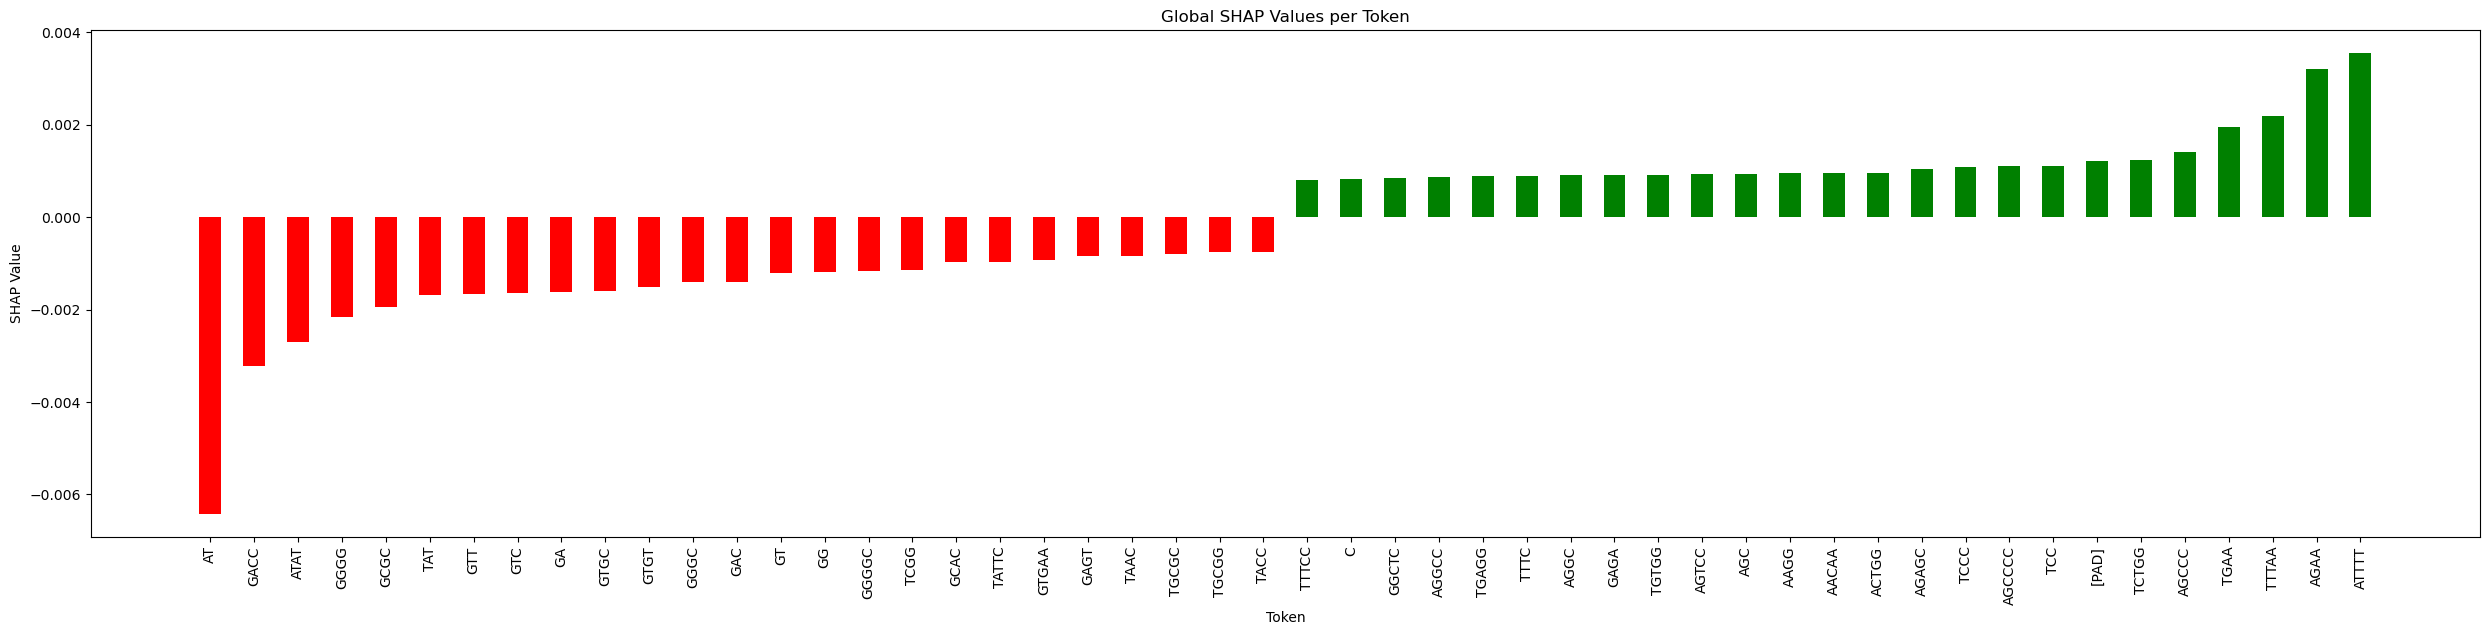

In [ ]:
plot_shap_values(combined_dict, "Global")

local SHAP

In [ ]:
def shap_values_local(record_num):
    # Create a defaultdict with float as the default factory function
    shap_value_per_token = defaultdict(float)

    # Iterate over the tokens in the specified record
    for j, token in enumerate(shap_values.data[record_num]):
        shap_value_for_token_in_seq = shap_values.values[record_num, j, 1]
        shap_value_per_token[token] += shap_value_for_token_in_seq

    # Change keys from tokens to sub-sequence features
    features_shap_value_dict = {}
    for key, item in shap_value_per_token.items():
        detokenized_feature = tokens_and_features_dict.get(key, key)  # Use the key if it doesn't exist in the dict
        features_shap_value_dict[detokenized_feature] = item

    # Remove special tokens if they exist in the dictionary
    special_tokens = ['[PAD]', '[SEP]', '[CLS]']
    for token in special_tokens:
        if token in features_shap_value_dict:
            del features_shap_value_dict[token]

    return features_shap_value_dict

In [ ]:
shap_values_record7 = shap_values_local(57)
shap_values_record1 = shap_values_local(1)
shap_values_record2 = shap_values_local(2)

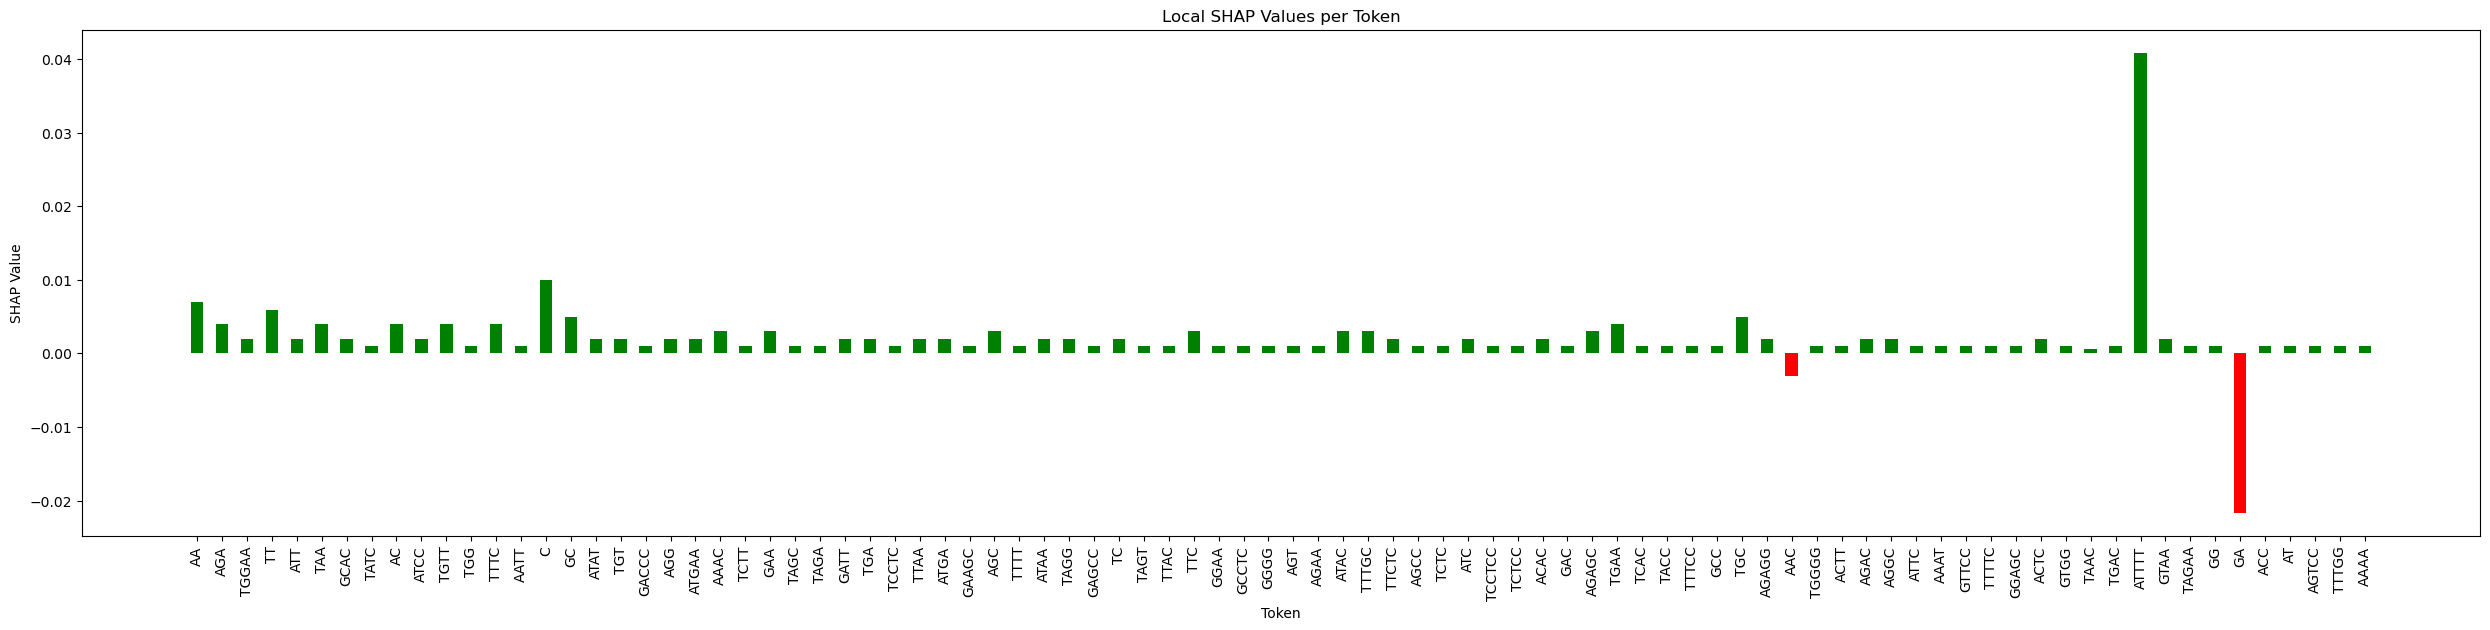

In [ ]:
plot_shap_values(shap_values_record7, "Local")

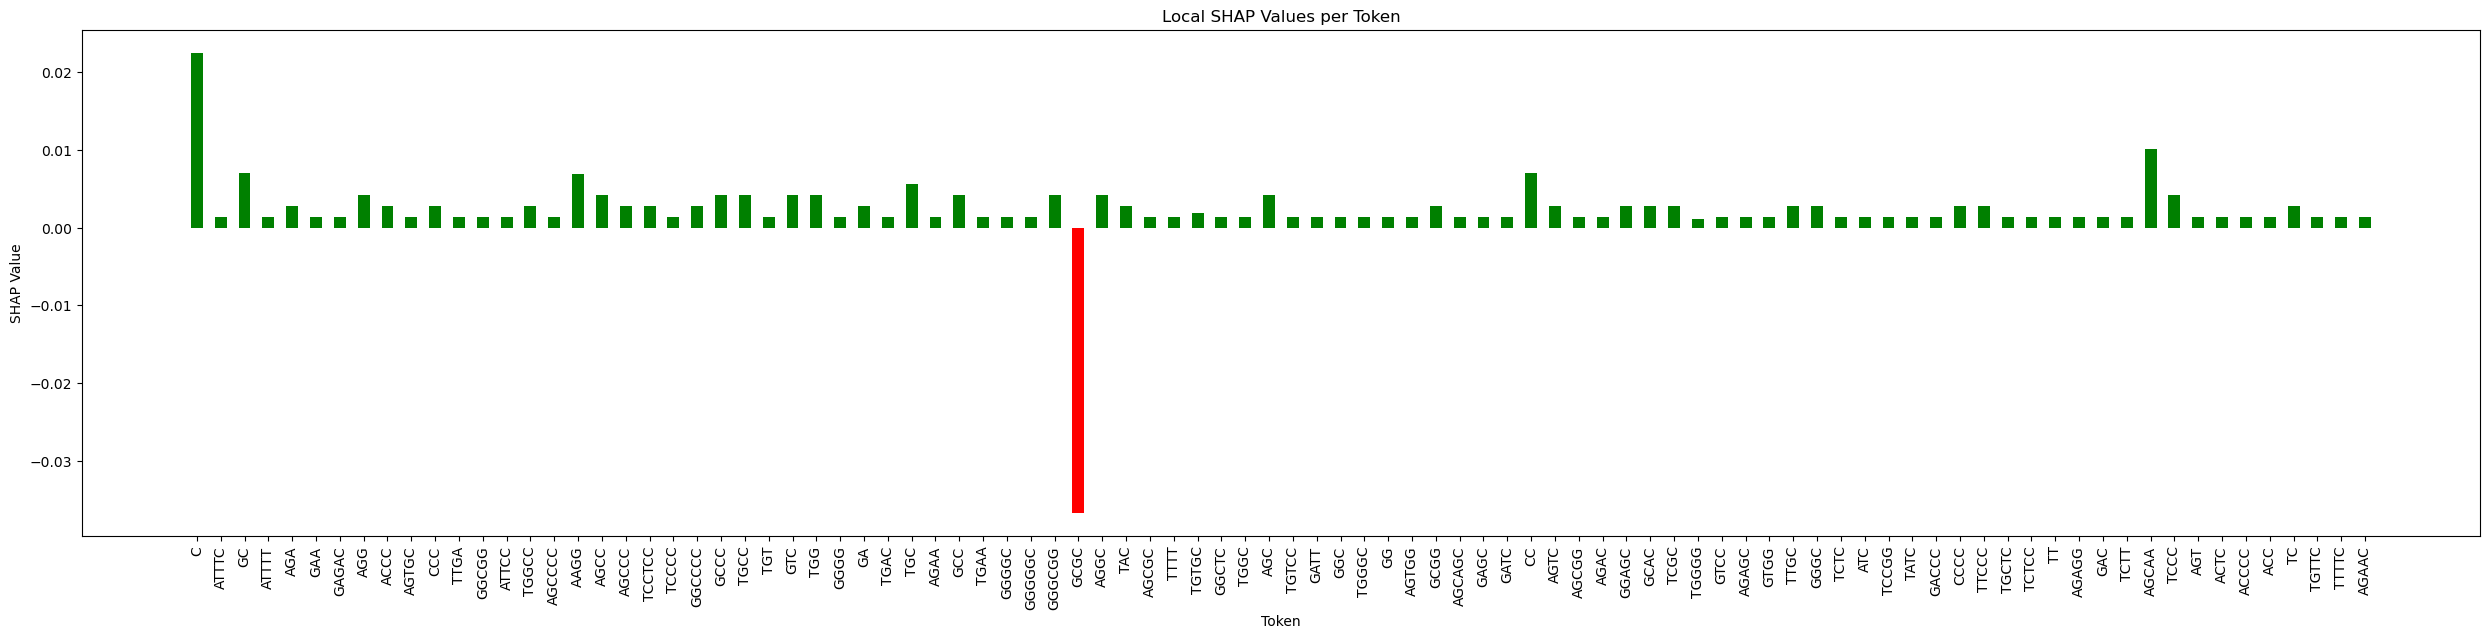

In [ ]:
plot_shap_values(shap_values_record1, "Local")

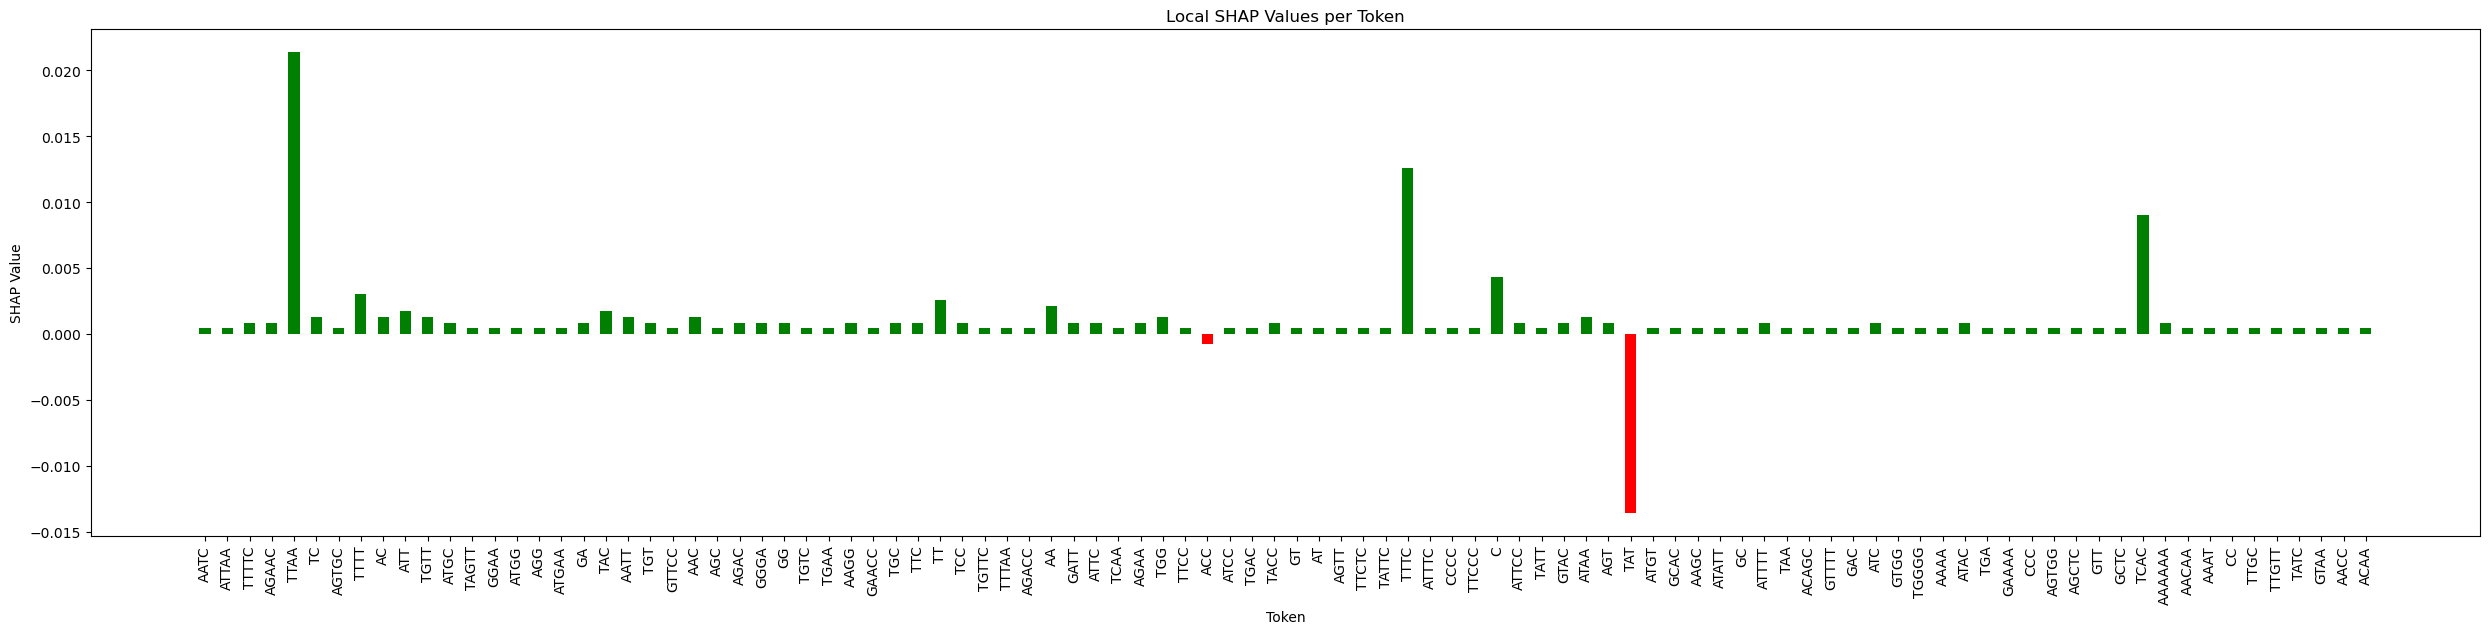

In [ ]:
plot_shap_values(shap_values_record2, "Local")

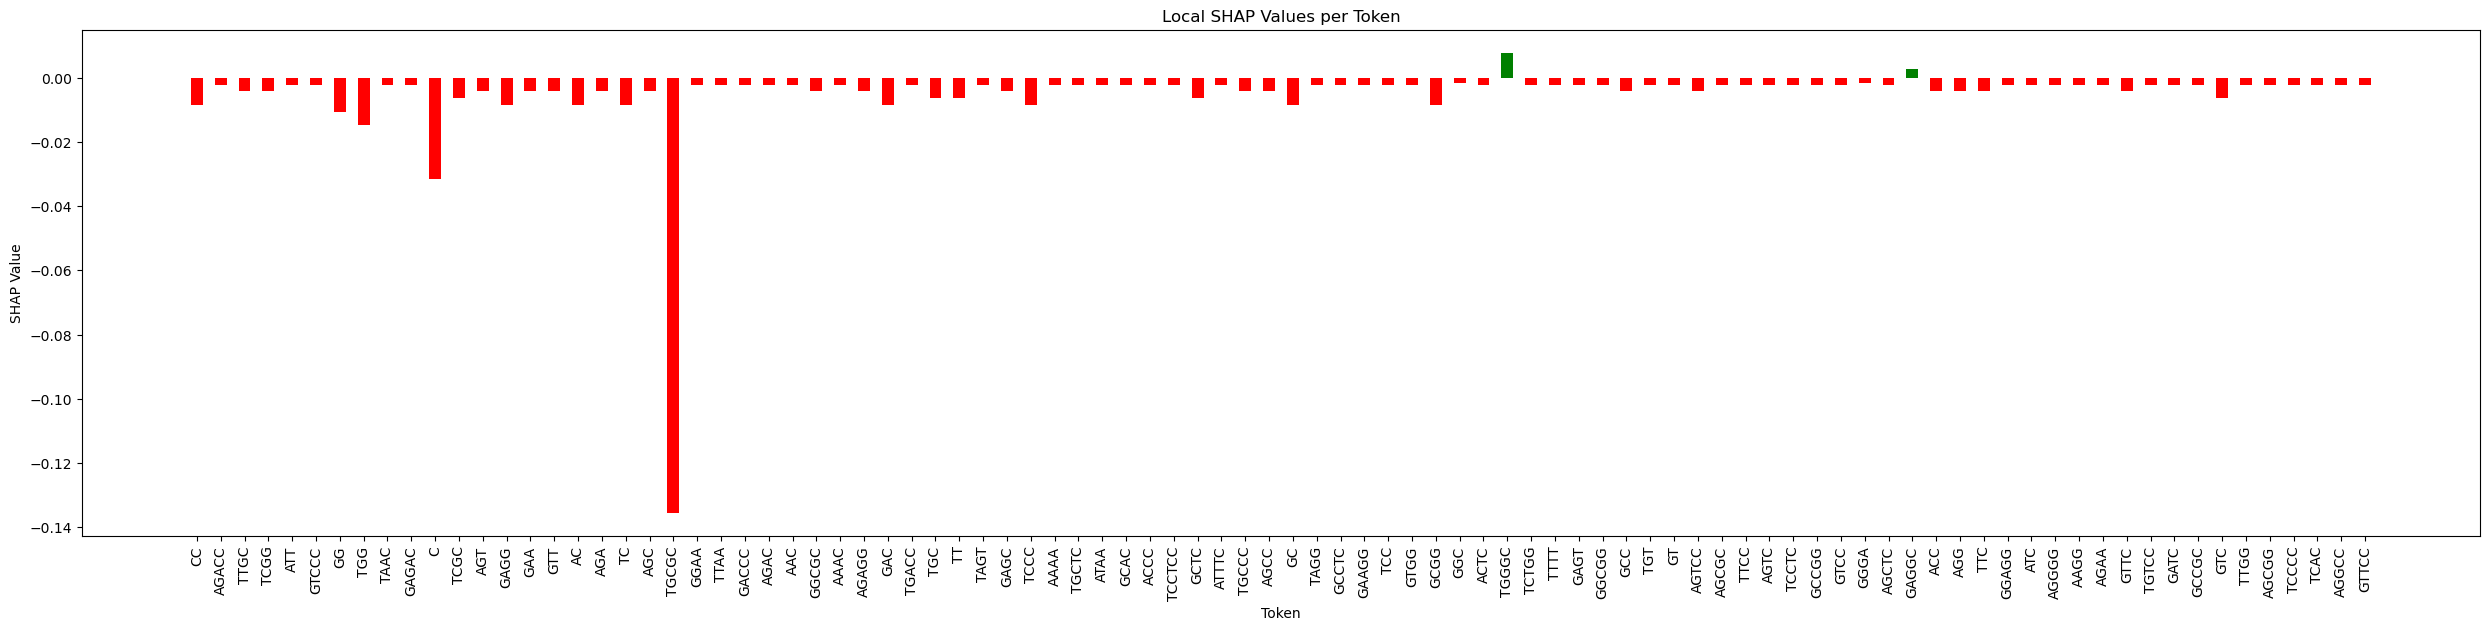

In [ ]:
shap_values_record6 = shap_values_local(6)
plot_shap_values(shap_values_record6, "Local")

# results plots

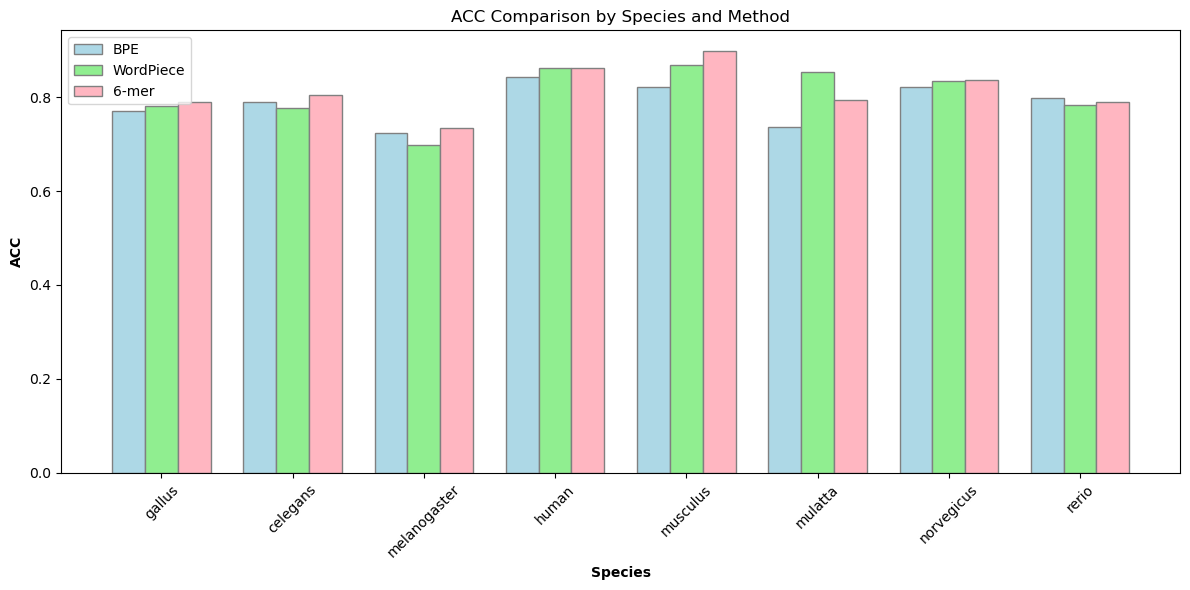

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Organizing the data
data = {
    'Species': ['gallus', 'gallus', 'gallus', 'celegans', 'celegans', 'celegans', 'melanogaster', 'melanogaster', 'melanogaster',
                'human', 'human', 'human', 'musculus', 'musculus', 'musculus', 'mulatta', 'mulatta', 'mulatta',
                'norvegicus', 'norvegicus', 'norvegicus', 'rerio', 'rerio', 'rerio'],
    'Method': ['BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer',
               'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer',
               'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer'],
    'ACC': [0.7704, 0.7815, 0.7889, 0.7906, 0.7759, 0.8054, 0.724, 0.6981, 0.7346, 0.842, 0.8616, 0.8616,
            0.821, 0.8686, 0.8973, 0.7353, 0.8529, 0.7941, 0.8221, 0.8344, 0.8374, 0.7986, 0.7822, 0.7904]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Define the species and methods
species = ['gallus', 'celegans', 'melanogaster', 'human', 'musculus', 'mulatta', 'norvegicus', 'rerio']
methods = ['BPE', 'WordPiece', '6-mer']

# Creating a bar plot for ACC
fig, ax = plt.subplots(figsize=(12, 6))

# Setting the bar width and positions
bar_width = 0.25
r1 = np.arange(len(species))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
ax.bar(r1, df[df['Method'] == 'BPE']['ACC'], color='#ADD8E6', width=bar_width, edgecolor='grey', label='BPE')
ax.bar(r2, df[df['Method'] == 'WordPiece']['ACC'], color='#90EE90', width=bar_width, edgecolor='grey', label='WordPiece')
ax.bar(r3, df[df['Method'] == '6-mer']['ACC'], color='#FFB6C1', width=bar_width, edgecolor='grey', label='6-mer')

# Adding labels and title
ax.set_xlabel('Species', fontweight='bold')
ax.set_ylabel('ACC', fontweight='bold')
ax.set_title('ACC Comparison by Species and Method')
ax.set_xticks([r + bar_width for r in range(len(species))])
ax.set_xticklabels(species, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

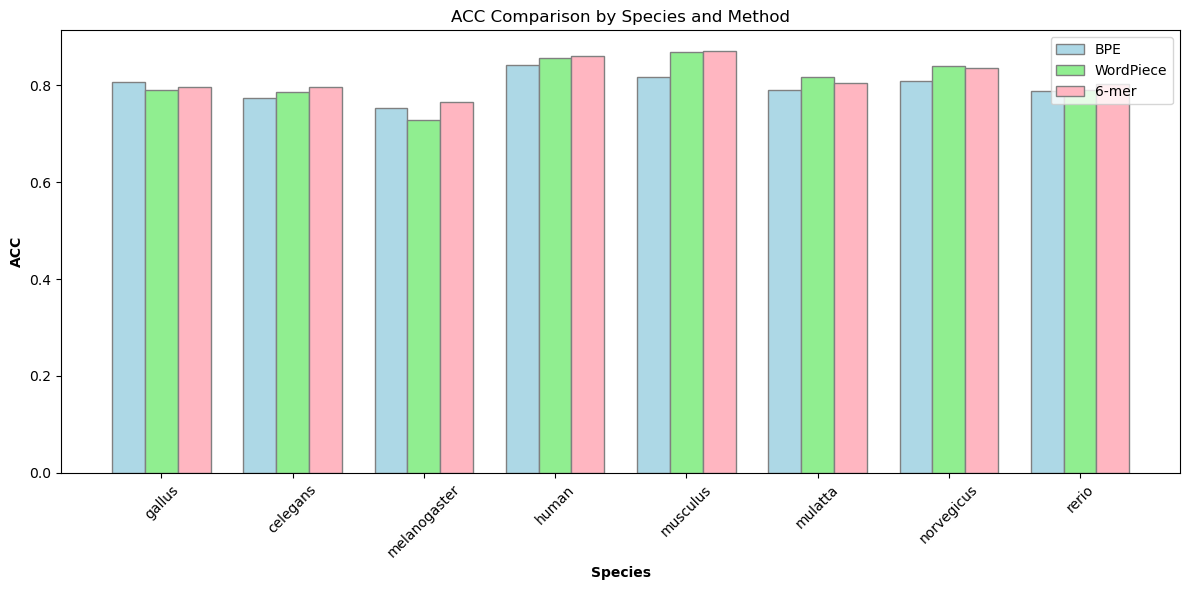

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Organizing the data
data_acc = {
    'Species': ['gallus', 'gallus', 'gallus', 'celegans', 'celegans', 'celegans', 'melanogaster', 'melanogaster', 'melanogaster',
                'human', 'human', 'human', 'musculus', 'musculus', 'musculus', 'mulatta', 'mulatta', 'mulatta',
                'norvegicus', 'norvegicus', 'norvegicus', 'rerio', 'rerio', 'rerio'],
    'Method': ['BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer',
               'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer',
               'BPE', 'WordPiece', '6-mer', 'BPE', 'WordPiece', '6-mer'],
    'ACC': [0.8063, 0.7896, 0.7969, 0.774, 0.787, 0.7965, 0.7532, 0.7283, 0.7654, 0.8429, 0.857, 0.8599,
           0.8172, 0.8688, 0.8702, 0.7908, 0.8164, 0.8049, 0.8081, 0.8409, 0.8365, 0.7881, 0.7909, 0.803]
}

# Creating the DataFrame
df_acc = pd.DataFrame(data_acc)

# Define the species and methods
species = ['gallus', 'celegans', 'melanogaster', 'human', 'musculus', 'mulatta', 'norvegicus', 'rerio']
methods = ['BPE', 'WordPiece', '6-mer']

# Creating a bar plot for ACC
fig, ax = plt.subplots(figsize=(12, 6))

# Setting the bar width and positions
bar_width = 0.25
r1 = np.arange(len(species))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars with pastel colors
ax.bar(r1, df_acc[df_acc['Method'] == 'BPE']['ACC'], color='#ADD8E6', width=bar_width, edgecolor='grey', label='BPE')
ax.bar(r2, df_acc[df_acc['Method'] == 'WordPiece']['ACC'], color='#90EE90', width=bar_width, edgecolor='grey', label='WordPiece')
ax.bar(r3, df_acc[df_acc['Method'] == '6-mer']['ACC'], color='#FFB6C1', width=bar_width, edgecolor='grey', label='6-mer')

# Adding labels and title
ax.set_xlabel('Species', fontweight='bold')
ax.set_ylabel('ACC', fontweight='bold')
ax.set_title('ACC Comparison by Species and Method')
ax.set_xticks([r + bar_width for r in range(len(species))])
ax.set_xticklabels(species, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


#### second experiment - wpc

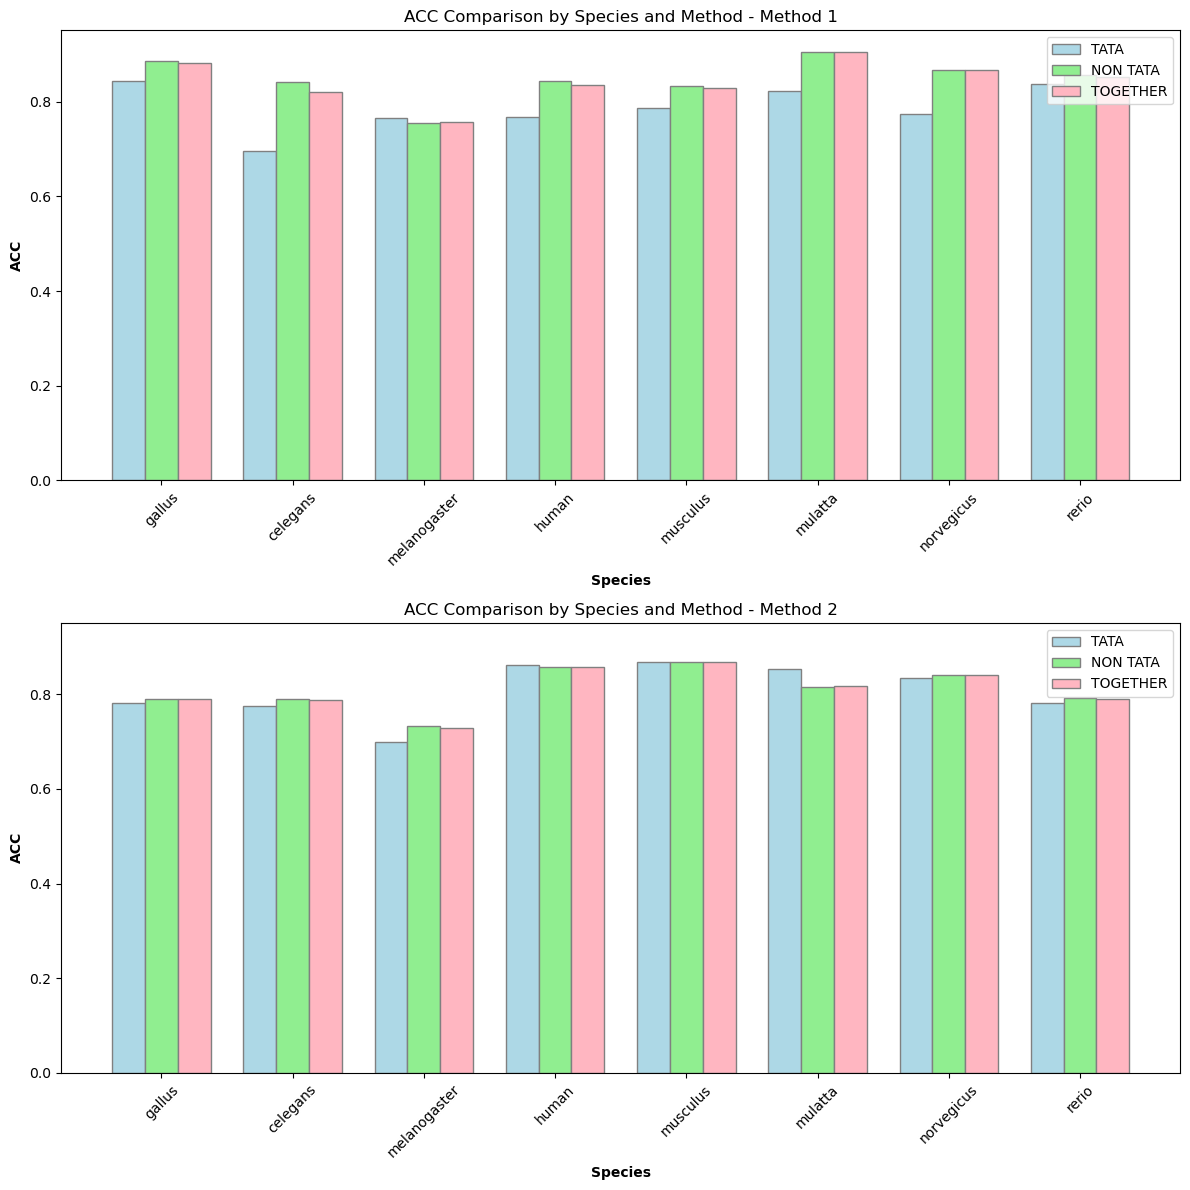

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Organizing the data for Method 1
data_method1_acc = {
    'Species': ['gallus', 'gallus', 'gallus', 'celegans', 'celegans', 'celegans', 'melanogaster', 'melanogaster', 'melanogaster',
                'human', 'human', 'human', 'musculus', 'musculus', 'musculus', 'mulatta', 'mulatta', 'mulatta',
                'norvegicus', 'norvegicus', 'norvegicus', 'rerio', 'rerio', 'rerio'],
    'Method': ['TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER',
               'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER',
               'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER'],
    'ACC': [0.8433, 0.8869, 0.8821, 0.6964, 0.8417, 0.821, 0.76609, 0.7555, 0.7573, 0.7681, 0.8428, 0.8351,
           0.7877, 0.8342, 0.8281, 0.8235, 0.9055, 0.9046, 0.7737, 0.8666, 0.8666, 0.8373, 0.8569, 0.853]
}

# Creating the DataFrame
df_method1_acc = pd.DataFrame(data_method1_acc)

# Method 2 data
data_method2_acc = {
    'Species': ['gallus', 'gallus', 'gallus', 'celegans', 'celegans', 'celegans', 'melanogaster', 'melanogaster', 'melanogaster',
                'human', 'human', 'human', 'musculus', 'musculus', 'musculus', 'mulatta', 'mulatta', 'mulatta',
                'norvegicus', 'norvegicus', 'norvegicus', 'rerio', 'rerio', 'rerio'],
    'Method': ['TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER',
               'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER',
               'TATA', 'NON TATA', 'TOGETHER', 'TATA', 'NON TATA', 'TOGETHER'],
    'ACC': [0.7815, 0.7906, 0.7896, 0.7759, 0.7889, 0.787, 0.6981, 0.7337, 0.7283, 0.8616, 0.8565, 0.857,
           0.8686, 0.8689, 0.8688, 0.8529, 0.816, 0.8164, 0.8344, 0.8414, 0.8409, 0.7822, 0.793, 0.7909]
}

# Creating the DataFrame
df_method2_acc = pd.DataFrame(data_method2_acc)

# Define the species and methods
species = ['gallus', 'celegans', 'melanogaster', 'human', 'musculus', 'mulatta', 'norvegicus', 'rerio']
methods = ['TATA', 'NON TATA', 'TOGETHER']

# Creating subplots for ACC
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharey=True)

# Setting the bar width and positions for Method 1
bar_width = 0.25
r1 = np.arange(len(species))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting Method 1 bars with pastel colors
axs[0].bar(r1, df_method1_acc[df_method1_acc['Method'] == 'TATA']['ACC'], color='#ADD8E6', width=bar_width, edgecolor='grey', label='TATA')
axs[0].bar(r2, df_method1_acc[df_method1_acc['Method'] == 'NON TATA']['ACC'], color='#90EE90', width=bar_width, edgecolor='grey', label='NON TATA')
axs[0].bar(r3, df_method1_acc[df_method1_acc['Method'] == 'TOGETHER']['ACC'], color='#FFB6C1', width=bar_width, edgecolor='grey', label='TOGETHER')

# Adding labels and title for Method 1
axs[0].set_xlabel('Species', fontweight='bold')
axs[0].set_ylabel('ACC', fontweight='bold')
axs[0].set_title('ACC Comparison by Species and Method - Method 1')
axs[0].set_xticks([r + bar_width for r in range(len(species))])
axs[0].set_xticklabels(species, rotation=45)
axs[0].legend()

# Plotting Method 2 bars with pastel colors
axs[1].bar(r1, df_method2_acc[df_method2_acc['Method'] == 'TATA']['ACC'], color='#ADD8E6', width=bar_width, edgecolor='grey', label='TATA')
axs[1].bar(r2, df_method2_acc[df_method2_acc['Method'] == 'NON TATA']['ACC'], color='#90EE90', width=bar_width, edgecolor='grey', label='NON TATA')
axs[1].bar(r3, df_method2_acc[df_method2_acc['Method'] == 'TOGETHER']['ACC'], color='#FFB6C1', width=bar_width, edgecolor='grey', label='TOGETHER')

# Adding labels and title for Method 2
axs[1].set_xlabel('Species', fontweight='bold')
axs[1].set_ylabel('ACC', fontweight='bold')
axs[1].set_title('ACC Comparison by Species and Method - Method 2')
axs[1].set_xticks([r + bar_width for r in range(len(species))])
axs[1].set_xticklabels(species, rotation=45)
axs[1].legend()

plt.tight_layout()
plt.show()